In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.transforms import GaussianBlur, ToTensor, ToPILImage, RandomCrop, Compose, Resize, Normalize
from torchvision.datasets import CIFAR10, Flickr8k, CelebA
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001
image_size = 28

# Gaussian Pyramid Constants
num_scales = 3
scale_factor = 2

# Define the transformations to apply to the CIFAR-10 data
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

download = True
# Define the training and test datasets
train_dataset = datasets.Flowers102(root='./data', split="train", download=download, transform=data_transforms)

# Define the dataloaders to load the data in batches during training and testing
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader = train_loader

In [55]:
# Define the network architecture with feature pyramid
class CompletionModel(nn.Module):
    def __init__(self, num_scales=3):
        super(CompletionModel, self).__init__()
        self.num_scales = num_scales

        # Define layers for each scale in the feature pyramid
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.channel_reducers = nn.ModuleList()  # 1x1 convolution layers to reduce channels
#         self.downsamplers = nn.ModuleList()
#         self.upsamplers = nn.ModuleList()
        
        for i in range(num_scales):
            encoder = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
                nn.ReLU()
            )
            self.encoders.append(encoder)

            decoder = nn.Sequential(
                nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU()
            )
            self.decoders.append(decoder)
            
            channel_reducer = nn.Conv2d(3, 512, kernel_size=1)  # 1x1 convolution layer to reduce channels
            self.channel_reducers.append(channel_reducer)
            
        self.upsampler = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=False)
        self.downsampler = nn.Upsample(scale_factor=1/scale_factor, mode='bilinear', align_corners=False)
            

    def forward(self, x):
        # Initialize list to store features from each scale
        features = []
        #print(f"x.shape: {x.shape}")

        # Forward pass through each scale in the feature pyramid
        for i in range(self.num_scales):
            encoder_output = self.encoders[i](x)
            features.append(encoder_output)
            #print(f"Feature size at {i}th scale: {features[-1].shape}")
            x = self.downsampler(x)

        # Decode the concatenated features
        shape_feats = list(features[-1].shape)
        shape_feats[1] = 3
        prev_output = None#torch.zeros(shape_feats).to(device)
        
        for i in range(self.num_scales):
            decoder_output = self.decoders[i](features[self.num_scales - i - 1])
            #print(f"decoder output shape: {decoder_output.shape}")
            if prev_output is None:
                prev_output = self.upsampler(decoder_output)
            else:
                #prev_output = self.channel_reducers[i](prev_output)
                prev_output = self.upsampler(prev_output+decoder_output)
            #print(f"prev_output.shape : {prev_output.shape}")
        
        #print(decoder_output.shape)
        return decoder_output


In [62]:
model = CompletionModel().to(device)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, _ in dataloader:
        images = images.to(device)
        
        occluded_image = images.clone()
        _, _, h, w = occluded_image.shape
        x = torch.randint(0, w // 2, (1,))
        y = torch.randint(0, h // 2, (1,))
        occluded_image[:, :, y:y + h // 2, x:x + w // 2] = 0
        # Forward pass and loss calculation
        completion_images = model(occluded_image.to(device))
        loss = criterion(completion_images[:, :, y:y + h // 2, x:x + w // 2], images[:, :, y:y + h // 2, x:x + w // 2])
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Compute the average loss for the epoch
    average_loss = running_loss / len(dataloader)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

# Generate completions for test images
model.eval()
pass

Epoch [1/50], Loss: 1.5183
Epoch [2/50], Loss: 1.4764
Epoch [3/50], Loss: 1.4430
Epoch [4/50], Loss: 1.4479
Epoch [5/50], Loss: 1.4272
Epoch [6/50], Loss: 1.4267
Epoch [7/50], Loss: 1.4207
Epoch [8/50], Loss: 1.4127
Epoch [9/50], Loss: 1.4061
Epoch [10/50], Loss: 1.4102
Epoch [11/50], Loss: 1.4088
Epoch [12/50], Loss: 1.4170
Epoch [13/50], Loss: 1.3939
Epoch [14/50], Loss: 1.3937
Epoch [15/50], Loss: 1.3785
Epoch [16/50], Loss: 1.3424
Epoch [17/50], Loss: 1.3424
Epoch [18/50], Loss: 1.3245
Epoch [19/50], Loss: 1.3148
Epoch [20/50], Loss: 1.3167
Epoch [21/50], Loss: 1.3044
Epoch [22/50], Loss: 1.3208
Epoch [23/50], Loss: 1.2911
Epoch [24/50], Loss: 1.3075
Epoch [25/50], Loss: 1.2778
Epoch [26/50], Loss: 1.3090
Epoch [27/50], Loss: 1.2917
Epoch [28/50], Loss: 1.3007
Epoch [29/50], Loss: 1.2842
Epoch [30/50], Loss: 1.2860
Epoch [31/50], Loss: 1.2920
Epoch [32/50], Loss: 1.2877
Epoch [33/50], Loss: 1.3047
Epoch [34/50], Loss: 1.2971
Epoch [35/50], Loss: 1.2758
Epoch [36/50], Loss: 1.2755
E

In [41]:
edge_len = int(128/8)
encoded = model.encoders[0](torch.randn((64, 3, edge_len, edge_len)).to(device))
print(encoded.shape)
model.decoders[0](encoded).shape

torch.Size([64, 512, 1, 1])


torch.Size([64, 3, 16, 16])

In [38]:
# model = CompletionModel().to(device)

# # Define the loss function
# criterion = nn.MSELoss()

# # Define the optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [67]:
from IPython.display import display, HTML

# # Define test transformations
# test_transform = Compose([
#     ToTensor()
# ])
test_dataset = datasets.Flowers102(root='./data', split="test", download=download, transform=data_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

# Load CIFAR-10 test dataset
# test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# # Create test data loader
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

with torch.no_grad():
    i = 0
    for images, _ in test_dataloader:
        images = images.to(device)
        
        occluded_image = images.clone()
        _, _, h, w = occluded_image.shape
        x = torch.randint(0, w // 2, (1,))
        y = torch.randint(0, h // 2, (1,))
        occluded_image[:, :, y:y + h // 2, x:x + w // 2] = 0
        
        ########
        
        # Generate completions using the model
        completions = model(occluded_image.to(device))

        # Convert tensors to PIL images for visualization
        to_pil = ToPILImage()
        true_img = to_pil(images.cpu().squeeze(0))
        original_img = to_pil(occluded_image.cpu().squeeze(0))
        
        occluded_image[:, :, y:y + h // 2, x:x + w // 2] = completions[:, :, y:y + h // 2, x:x + w // 2]
        completed_img = to_pil(occluded_image.cpu().squeeze(0))
        
        # Define the HTML style for larger images
        html_style = "<style>img { max-width: 100%; height: auto; }</style>"
        i+=1
        if i==3:
            break

        # Display the original and completed images with larger size
#         display(HTML(html_style))

#         # Display the original and completed images
#         display(original_img)
#         display(completed_img)

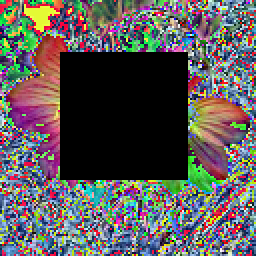

In [68]:
from PIL import Image
original_img.resize((original_img.width * 2,original_img.height * 2),
                                                    Image.NEAREST)


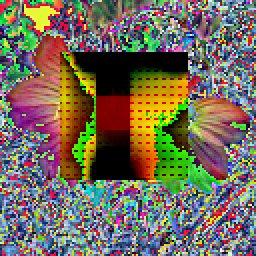

In [69]:
completed_img.resize((completed_img.width * 2,completed_img.height * 2),
                                                    Image.NEAREST)

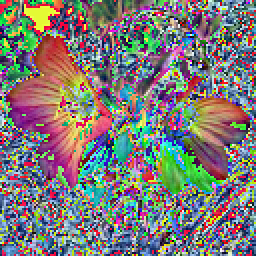

In [70]:
true_img.resize((true_img.width * 2,true_img.height * 2),
                                                    Image.NEAREST)


## Downstream evaluation

In the SSL model trained above, we have multiple encoders. All of these specialize in capturing the information at a specific level.

In [74]:
torch.save(model.state_dict(), 'ssl_model.pth')

In [5]:
model.load_state_dict(torch.load('ssl_model.pth'))

<All keys matched successfully>

In [44]:
# nn.Sequential(model.encoders[0], nn.Flatten(), nn.C))

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=256, out_features=1, bias=True)
)

In [72]:
model.encoders[2](torch.randn(1, 3, 128, 128).to(device)).shape

torch.Size([1, 512, 8, 8])

In [73]:
# nn.AdaptiveAvgPool2d((5, 7))(torch.randn(1, 64, 8, 9)).shape

torch.Size([1, 64, 5, 7])

In [76]:
input_shape = (256, 128, 128)
# Define the classification model
classification_model = nn.Sequential(
    # Convolutional layers
    nn.AdaptiveAvgPool2d((1, 1)),
#     # Flatten the feature maps
    nn.Flatten(),

#     # Fully connected layers
    nn.Linear(num_scales*512, 256),
    nn.ReLU(),
    nn.Linear(256, 102)  # num_classes is the number of classes for classification
)

# Print the classification model architecture
print(classification_model)

Sequential(
  (0): AdaptiveAvgPool2d(output_size=(1, 1))
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=1536, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=102, bias=True)
)


In [77]:
# classification_model.cuda()(model.encoders[2](torch.randn(1, 3, 128, 128).cuda())).shape
# torch.cuda.empty_cache()

In [78]:
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(classification_model.parameters(), lr=learning_rate)

In [95]:
def model_eval(model, classification_model, dataloader):
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            
            encoder_outputs = []
            for j in range(num_scales):
                encoder_outputs.append(model.encoders[j](images))
            encoder_outputs_stacked = torch.cat(encoder_outputs, dim=1)
            outputs = classification_model(encoder_outputs_stacked)
        
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
#             print(predicted.shape, labels.shape, total, images.shape, outputs.data.shape)
#             print(encoder_outputs_stacked.shape)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [96]:
num_epochs = 10
classification_model = classification_model.to(device)

log_train_every = 1
log_test_every = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        encoder_outputs = []
        for j in range(num_scales):
            encoder_outputs.append(model.encoders[j](inputs))
        encoder_outputs_stacked = torch.cat(encoder_outputs, dim=1)
        outputs = classification_model(encoder_outputs_stacked)
        
        loss = criterion(outputs, labels)
        
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    # compute training & testing accuracy every couple of iterations        
    if (epoch+1) % log_train_every == 0:
        train_accuracy = model_eval(model, classification_model, train_loader)

        # Log the loss
        #writer.add_scalar('Loss/train', loss.cpu().item(), epoch * len(train_loader) + i)

        # Log the training accuracy
        #writer.add_scalar('Accuracy/train', train_accuracy, epoch * len(train_loader) + i)
        print(f"Epoch {epoch+1} : Loss: {running_loss} Accuracy: {train_accuracy}")
        
    if (epoch+1) % log_test_every == 0:
        test_accuracy = model_eval(model, classification_model, test_dataloader)

        # Log the test accuracy
        #writer.add_scalar('Accuracy/test', test_accuracy, epoch * len(train_loader) + i)
        print(f"Epoch {epoch+1} : Test Accuracy: {test_accuracy}")
        
# writer.close()
print("Training finished.")

Epoch 1 : Loss: 64.90077042579651 Accuracy: 9.313725490196079
Epoch 2 : Loss: 63.63122200965881 Accuracy: 11.372549019607844
Epoch 3 : Loss: 62.531811237335205 Accuracy: 10.882352941176471
Epoch 4 : Loss: 61.70091223716736 Accuracy: 13.235294117647058
Epoch 5 : Loss: 60.74516940116882 Accuracy: 14.019607843137255
Epoch 5 : Test Accuracy: 8.537973654252724
Epoch 6 : Loss: 59.933398723602295 Accuracy: 14.313725490196079
Epoch 7 : Loss: 59.127076387405396 Accuracy: 14.019607843137255
Epoch 8 : Loss: 58.40982794761658 Accuracy: 15.686274509803921
Epoch 9 : Loss: 57.68313813209534 Accuracy: 16.666666666666668
Epoch 10 : Loss: 57.04532504081726 Accuracy: 17.745098039215687
Epoch 10 : Test Accuracy: 9.806472597170272
Training finished.
